In [1]:
from tinytag import TinyTag
import librosa
import os
import re
import numpy as np
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import random
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler


In [2]:
class RekordboxAudioDataset(Dataset):
    def __init__(self, audio_dir, transform=None, target_length=1292):
        super().__init__()
        self.audio_dir = audio_dir
        self.transform = transform
        self.target_length = target_length
        self.audio_files = []
        self.true_tempos = []
        self.features = []
        
        self._load_audio_files()
        
    def _pad_or_truncate_features(self, features):
        if features.shape[1] < self.target_length:
            padded = np.zeros((features.shape[0], self.target_length))
            padded[:, :features.shape[1]] = features
            return padded
        return features[:, :self.target_length]
        
    def __len__(self):
        return len(self.audio_files)
    
    def normalize_tempo(self, librosa_tempo, true_tempo):
        while librosa_tempo < 78:
            librosa_tempo *= 2
        while librosa_tempo > 155:
            librosa_tempo /= 2
            
        if librosa_tempo * 2 <= 155:
            if abs(librosa_tempo * 2 - true_tempo) < abs(librosa_tempo - true_tempo):
                librosa_tempo *= 2
        if librosa_tempo / 2 >= 78:
            if abs(librosa_tempo / 2 - true_tempo) < abs(librosa_tempo - true_tempo):
                librosa_tempo /= 2
                
        return librosa_tempo
    
    def _extract_features(self, y, sr, true_tempo):
        try:
            # Use librosa to estimate tempo
            onset_env = librosa.onset.onset_strength(y=y, sr=sr)
            tempo_librosa, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
            
            # Normalize the estimated tempo
            tempo_librosa = self.normalize_tempo(tempo_librosa, true_tempo)
            
            # Normalize librosa estimated tempo to [0,1]
            tempo_librosa_norm = (tempo_librosa - 78) / 77
            
            # Compute MFCCs
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfccs = librosa.util.fix_length(mfccs, size=self.target_length)
            
            # Compute spectral centroid
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
            spectral_centroid = librosa.util.fix_length(spectral_centroid, size=self.target_length)
            
            mfccs = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / (np.std(mfccs, axis=1, keepdims=True) + 1e-8)
    
            # Normalize spectral centroid
            spectral_centroid = (spectral_centroid - np.mean(spectral_centroid)) / (np.std(spectral_centroid) + 1e-8)
            
            # Stack features
            tempo_feature = np.full((1, self.target_length), tempo_librosa_norm)
            features = np.vstack([tempo_feature, mfccs, spectral_centroid])
            
            return features
        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            return np.zeros((15, self.target_length))
    
    def _load_audio_files(self):
        tempo_pattern = re.compile(r'^(\d+\.?\d*)\s+(.+)$')
        all_audio_files = [f for f in os.listdir(self.audio_dir) 
                        if f.endswith(('.mp3', '.wav', '.aiff', '.m4a'))]
        
        for filename in all_audio_files:
            match = tempo_pattern.match(filename)
            if match:
                try:
                    true_tempo = float(match.group(1))
                    audio_path = os.path.join(self.audio_dir, filename)
                    
                    tag = TinyTag.get(audio_path)
                    offset = tag.duration / 3 if tag.duration else 0
                    y, sr = librosa.load(audio_path, offset=offset, duration=30)
                    
                    features = self._extract_features(y, sr, true_tempo)
                    features = self._pad_or_truncate_features(features)
                    
                    self.audio_files.append(filename)
                    self.true_tempos.append(true_tempo)
                    self.features.append(features)
                    
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
                    continue
            else:
                continue  # If filename doesn't match the pattern, skip it
    
    def __getitem__(self, idx):
        true_tempo = self.true_tempos[idx]
        features = self.features[idx]
        
        if self.transform:
            features = self.transform(features)
        
        features = torch.FloatTensor(features)
        # Normalize the true tempo for the target
        true_tempo_norm = (true_tempo - 78) / 77
        target = torch.tensor([true_tempo_norm], dtype=torch.float32)
        
        return features, target

In [3]:
class AugmentedRekordboxDataset(Dataset):
    def __init__(self, base_dataset, augmentations_per_sample=4):
        self.base_dataset = base_dataset
        self.augmentations_per_sample = augmentations_per_sample
        self.feature_length = base_dataset.target_length
        self.feature_shape = (15, self.feature_length)

    def __len__(self):
        return len(self.base_dataset) * self.augmentations_per_sample

    def __getitem__(self, idx):
        original_idx = idx // self.augmentations_per_sample
        features, target = self.base_dataset[original_idx]
        original_tempo_norm = features[0, 0].item()  # Get the original tempo feature

        if idx % self.augmentations_per_sample == 0:
            return features, target

        features_np = features.numpy()
        aug_type = idx % self.augmentations_per_sample

        if aug_type == 1:
            features_np, new_tempo_norm, stretch_factor = self._time_stretch(features_np, original_tempo_norm)
            
            # Adjust the target tempo
            # Convert normalized target back to BPM
            target_bpm = target.item() * 77 + 78
            # Adjust tempo BPM according to stretch factor
            new_target_bpm = target_bpm / stretch_factor
            # Normalize the adjusted BPM back to [0, 1]
            new_target_norm = (new_target_bpm - 78) / 77
            target = torch.tensor([new_target_norm], dtype=torch.float32)

        elif aug_type == 2:
            features_np = self._mask_augment(features_np)

        elif aug_type == 3:
            features_np = self._add_noise(features_np)

        return torch.FloatTensor(features_np), target

    def _time_stretch(self, features, original_tempo_norm):
        stretch_factor = np.random.uniform(0.95, 1.05)
        dynamic_features = features[1:]  # Exclude tempo feature

        # Convert original tempo feature back to BPM
        tempo_bpm = original_tempo_norm * 77 + 78
        # Adjust tempo BPM according to stretch factor
        new_tempo_bpm = tempo_bpm / stretch_factor
        # Normalize the adjusted BPM back to [0, 1]
        new_tempo_norm = (new_tempo_bpm - 78) / 77
        features[0] = new_tempo_norm

        time_axis = self.feature_length
        stretched_length = int(time_axis * stretch_factor)

        stretched = np.zeros((features.shape[0], time_axis))
        stretched[0] = features[0]  # Updated tempo feature

        indices = np.linspace(0, time_axis - 1, stretched_length)
        for i in range(dynamic_features.shape[0]):
            # Time-stretch dynamic features
            temp = np.interp(indices, np.arange(time_axis), dynamic_features[i])
            stretched[i + 1] = np.interp(np.arange(time_axis), np.arange(stretched_length), temp)

        return stretched, new_tempo_norm, stretch_factor

    def _mask_augment(self, features):
        features = features.copy()
        mask_size = random.randint(32, min(128, self.feature_length))
        mask_start = random.randint(0, self.feature_length - mask_size)
        features[1:, mask_start:mask_start + mask_size] = 0  # Mask dynamic features
        return features

    def _add_noise(self, features):
        noise = np.random.normal(0, 0.01, (features.shape[0], self.feature_length))
        noise[0] = 0  # Don't add noise to tempo feature
        return features + noise

In [4]:
# Initialize datasets
audio_dir = "./TellerNet/data/beatbank_train_audios"
base_dataset = RekordboxAudioDataset(audio_dir, target_length=1292)
aug_dataset = AugmentedRekordboxDataset(base_dataset)

# Verify shapes
if len(base_dataset) > 0:
    base_features, base_target = base_dataset[0]
    print(f"Base shape: {base_features.shape}")
    print(f"Base target: {base_target}")
else:
    print("Base dataset is empty.")

if len(aug_dataset) > 0:
    aug_features, aug_target = aug_dataset[0]
    print(f"Augmented shape: {aug_features.shape}")
    print(f"Augmented target: {aug_target}")
else:
    print("Augmented dataset is empty.")

Base shape: torch.Size([15, 1292])
Base target: tensor([0.2857])
Augmented shape: torch.Size([15, 1292])
Augmented target: tensor([0.2857])


In [5]:
# Dataset parameters
target_length = 1292  # Length to pad or truncate features
batch_size = 32       # Increased batch size for more stable gradients
test_size = 0.2       # Fraction of data to use for validation
random_seed = 42     # Random seed for reproducibility

# Training parameters
num_epochs = 1200       # Number of epochs for training
learning_rate = 0.0002 # Reduced learning rate for optimizer

# Model parameters
input_channels = 15   # Number of feature channels

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seeds for reproducibility
import random
import numpy as np

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

In [6]:
# Define scaling and descaling functions
def scale_tempo(tempo):
    return (tempo - 78) / 77

def descale_tempo(scaled_tempo):
    return scaled_tempo * 77 + 78

# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

# Get indices for splitting
dataset_size = len(aug_dataset)
indices = list(range(dataset_size))
train_indices, val_indices = train_test_split(
    indices, test_size=test_size, random_state=random_seed, shuffle=True
)

# Create samplers
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(aug_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(aug_dataset, batch_size=batch_size, sampler=val_sampler)

# Define the CNN model
class TellerNet(nn.Module):
    def __init__(self):
        super(TellerNet, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32, momentum=0.1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64, momentum=0.1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128, momentum=0.1)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        # Calculate the output length after convolution and pooling
        conv_output_length = self._calculate_output_length(target_length)
        self.fc1 = nn.Linear(128 * conv_output_length, 256)
        self.fc2 = nn.Linear(256, 1)  # Output is a single value (scaled tempo)

    def _calculate_output_length(self, input_length):
        # Calculate the length after three pooling layers
        length = input_length
        for _ in range(3):
            length = length // 2  # MaxPool with kernel_size=2 halves the length
        return length

    def forward(self, x):
        x = self.input_bn(x)
        x = self.pool1(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool2(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool3(nn.functional.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()

# Initialize the model, loss function, optimizer, and scheduler
model = TellerNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)


In [7]:
train_losses = []
val_losses = []
train_bpm_errors = []
val_bpm_errors = []
best_val_loss = float('inf')
best_model_state = None
epochs_without_improvement = 0
patience = 200  # Early stopping patience

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_bpm_error = 0.0
    for features, targets in train_loader:
        features = features.to(device).permute(0, 1, 2)  # Ensure features are (batch_size, channels, length)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets.squeeze())
        loss.backward()
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * features.size(0)

        # Compute BPM error
        predicted_tempo = descale_tempo(outputs.detach().cpu())
        true_tempo = descale_tempo(targets.squeeze().cpu())
        bpm_error = torch.abs(predicted_tempo - true_tempo)
        running_bpm_error += bpm_error.sum().item()

    epoch_train_loss = running_loss / len(train_indices)
    epoch_train_bpm_error = running_bpm_error / len(train_indices)
    train_losses.append(epoch_train_loss)
    train_bpm_errors.append(epoch_train_bpm_error)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    running_val_bpm_error = 0.0
    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device).permute(0, 1, 2)  # Ensure features are (batch_size, channels, length)
            targets = targets.to(device)
            outputs = model(features)
            loss = criterion(outputs, targets.squeeze())
            running_val_loss += loss.item() * features.size(0)

            # Compute BPM error
            predicted_tempo = descale_tempo(outputs.cpu())
            true_tempo = descale_tempo(targets.squeeze().cpu())
            bpm_error = torch.abs(predicted_tempo - true_tempo)
            running_val_bpm_error += bpm_error.sum().item()

    epoch_val_loss = running_val_loss / len(val_indices)
    epoch_val_bpm_error = running_val_bpm_error / len(val_indices)
    val_losses.append(epoch_val_loss)
    val_bpm_errors.append(epoch_val_bpm_error)

    # Step the scheduler
    scheduler.step(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Train BPM Error: {epoch_train_bpm_error:.2f}, '
          f'Validation Loss: {epoch_val_loss:.4f}, '
          f'Validation BPM Error: {epoch_val_bpm_error:.2f}')

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

# Save the best model to a .pth file
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
torch.save(best_model_state, f'model_{dt_string}.pth')

print("Best model saved to 'best_tempo_estimation_model.pth'")
print("average bpm error for best model: ", np.mean(val_bpm_errors))

Epoch [1/1200], Train Loss: 5.0638, Train BPM Error: 84.69, Validation Loss: 0.1137, Validation BPM Error: 18.78
Epoch [2/1200], Train Loss: 0.0398, Train BPM Error: 11.27, Validation Loss: 0.0572, Validation BPM Error: 14.11
Epoch [3/1200], Train Loss: 0.0194, Train BPM Error: 7.76, Validation Loss: 0.0161, Validation BPM Error: 7.07
Epoch [4/1200], Train Loss: 0.0117, Train BPM Error: 6.04, Validation Loss: 0.0110, Validation BPM Error: 5.50
Epoch [5/1200], Train Loss: 0.0194, Train BPM Error: 8.39, Validation Loss: 0.0112, Validation BPM Error: 5.15
Epoch [6/1200], Train Loss: 0.0161, Train BPM Error: 7.08, Validation Loss: 0.0084, Validation BPM Error: 5.07
Epoch [7/1200], Train Loss: 0.0060, Train BPM Error: 4.34, Validation Loss: 0.0061, Validation BPM Error: 4.11
Epoch [8/1200], Train Loss: 0.0053, Train BPM Error: 3.82, Validation Loss: 0.0108, Validation BPM Error: 6.17
Epoch [9/1200], Train Loss: 0.0045, Train BPM Error: 3.82, Validation Loss: 0.0153, Validation BPM Error: 8.

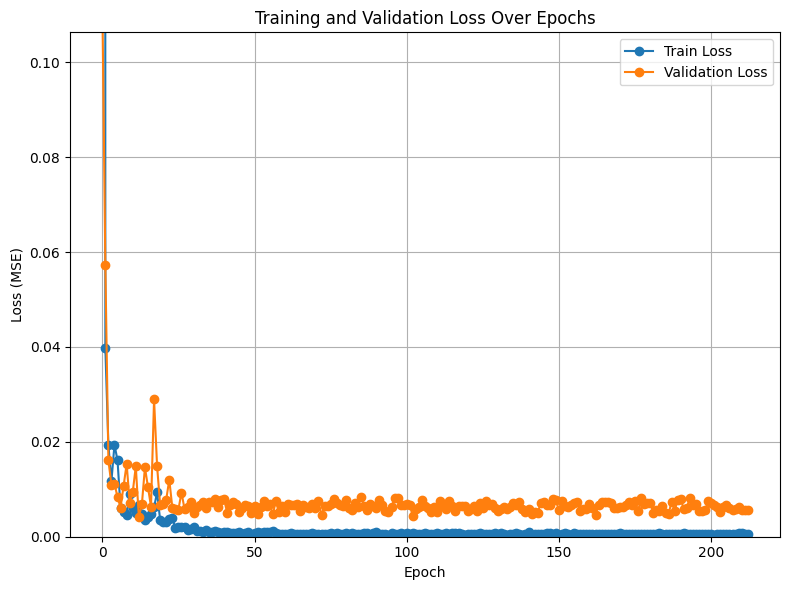

Loss plot saved to c:\Users\parke\OneDrive\Documents\GitHub\beat_teller_project\plots\training_validation_losses_20241203_183911.png


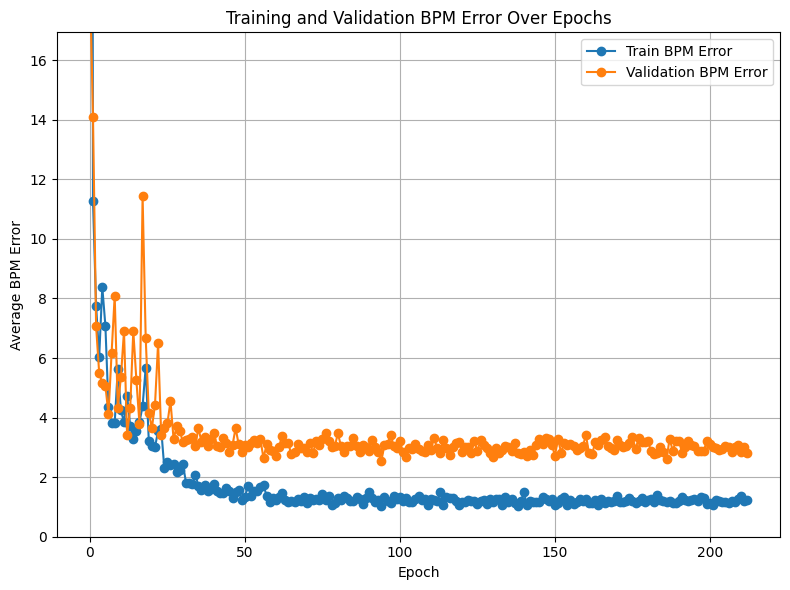

BPM error plot saved to c:\Users\parke\OneDrive\Documents\GitHub\beat_teller_project\plots\training_validation_bpm_errors_20241203_183911.png


In [8]:
# Create directories for plots if they don't exist
plt_dir = os.path.join(os.getcwd(), 'plots')
os.makedirs(plt_dir, exist_ok=True)

# Generate epochs range
epochs_range = list(range(len(train_losses)))

# Plot Training and Validation Loss in a separate figure
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.ylim([0, max(train_losses + val_losses) * .021])  # Adjust as needed
# Optionally use logarithmic scale
# plt.yscale('log')
plt.tight_layout()
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
loss_plot_filename = os.path.join(plt_dir, f'training_validation_losses_{dt_string}.png')
plt.savefig(loss_plot_filename)
plt.show()

print(f"Loss plot saved to {loss_plot_filename}")

# Plot Training and Validation BPM Error in a separate figure
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_bpm_errors, label='Train BPM Error', marker='o')
plt.plot(epochs_range, val_bpm_errors, label='Validation BPM Error', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average BPM Error')
plt.title('Training and Validation BPM Error Over Epochs')
plt.legend()
plt.grid(True)
# Adjust y-axis limits based on BPM error values
plt.ylim([0, max(train_bpm_errors + val_bpm_errors) * .2])
plt.tight_layout()
bpm_error_plot_filename = os.path.join(plt_dir, f'training_validation_bpm_errors_{dt_string}.png')
plt.savefig(bpm_error_plot_filename)
plt.show()

print(f"BPM error plot saved to {bpm_error_plot_filename}")

# K Fold Cross Validation

In [9]:
num_epochs = 1200
learning_rate = 0.0005
batch_size = 64
patience = 20  # Early stopping patience
k_folds = 5
random_seed = 24

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure reproducibility
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

# Initialize the dataset
audio_dir = "./TellerNet/data/beatbank_train_audios"
base_dataset = RekordboxAudioDataset(audio_dir, target_length=1292)
aug_dataset = AugmentedRekordboxDataset(base_dataset)

# Prepare cross-validation
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

# Lists to hold overall performance metrics
fold_train_losses = []
fold_val_losses = []
fold_train_bpm_errors = []
fold_val_bpm_errors = []

# Start cross-validation
for fold, (train_indices, val_indices) in enumerate(kfold.split(aug_dataset)):
    print(f'\nFold {fold+1}/{k_folds}')
    print('--------------------------------')
    
    # Sample elements randomly from the dataset, no replacement.
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    
    # Define data loaders for training and validation
    train_loader = DataLoader(aug_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(aug_dataset, batch_size=batch_size, sampler=val_sampler)
    
    # Initialize the model, optimizer, loss function, and scheduler for each fold
    model = TempoEstimationCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    criterion = nn.MSELoss()
    
    # Track metrics for this fold
    train_losses = []
    val_losses = []
    train_bpm_errors = []
    val_bpm_errors = []
    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_bpm_error = 0.0
        for features, targets in train_loader:
            features = features.to(device).permute(0, 1, 2)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets.squeeze())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * features.size(0)

            # Compute BPM error
            predicted_tempo = descale_tempo(outputs.detach().cpu())
            true_tempo = descale_tempo(targets.squeeze().cpu())
            bpm_error = torch.abs(predicted_tempo - true_tempo)
            running_bpm_error += bpm_error.sum().item()
        
        epoch_train_loss = running_loss / len(train_indices)
        epoch_train_bpm_error = running_bpm_error / len(train_indices)
        train_losses.append(epoch_train_loss)
        train_bpm_errors.append(epoch_train_bpm_error)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        running_val_bpm_error = 0.0
        with torch.no_grad():
            for features, targets in val_loader:
                features = features.to(device).permute(0, 1, 2)
                targets = targets.to(device)
                outputs = model(features)
                loss = criterion(outputs, targets.squeeze())
                running_val_loss += loss.item() * features.size(0)

                # Compute BPM error
                predicted_tempo = descale_tempo(outputs.cpu())
                true_tempo = descale_tempo(targets.squeeze().cpu())
                bpm_error = torch.abs(predicted_tempo - true_tempo)
                running_val_bpm_error += bpm_error.sum().item()
        
        epoch_val_loss = running_val_loss / len(val_indices)
        epoch_val_bpm_error = running_val_bpm_error / len(val_indices)
        val_losses.append(epoch_val_loss)
        val_bpm_errors.append(epoch_val_bpm_error)
        
        # Step the scheduler
        scheduler.step(epoch_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Train BPM Error: {epoch_train_bpm_error:.2f}, '
              f'Validation Loss: {epoch_val_loss:.4f}, '
              f'Validation BPM Error: {epoch_val_bpm_error:.2f}')
        
        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break
    
    # Save the best model for this fold
    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    model_filename = f'model_fold{fold+1}_{dt_string}.pth'
    torch.save(best_model_state, model_filename)
    print(f"Best model for fold {fold+1} saved to '{model_filename}'")
    
    # Store metrics for this fold
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_bpm_errors.append(train_bpm_errors)
    fold_val_bpm_errors.append(val_bpm_errors)

# After all folds, compute average metrics
avg_train_loss = np.mean([losses[-1] for losses in fold_train_losses])
avg_val_loss = np.mean([losses[-1] for losses in fold_val_losses])
avg_train_bpm_error = np.mean([errors[-1] for errors in fold_train_bpm_errors])
avg_val_bpm_error = np.mean([errors[-1] for errors in fold_val_bpm_errors])

print('\nCross-Validation Results')
print('------------------------')
print(f'Average Train Loss: {avg_train_loss:.4f}')
print(f'Average Validation Loss: {avg_val_loss:.4f}')
print(f'Average Train BPM Error: {avg_train_bpm_error:.2f}')
print(f'Average Validation BPM Error: {avg_val_bpm_error:.2f}')


Fold 1/5
--------------------------------


NameError: name 'TempoEstimationCNN' is not defined

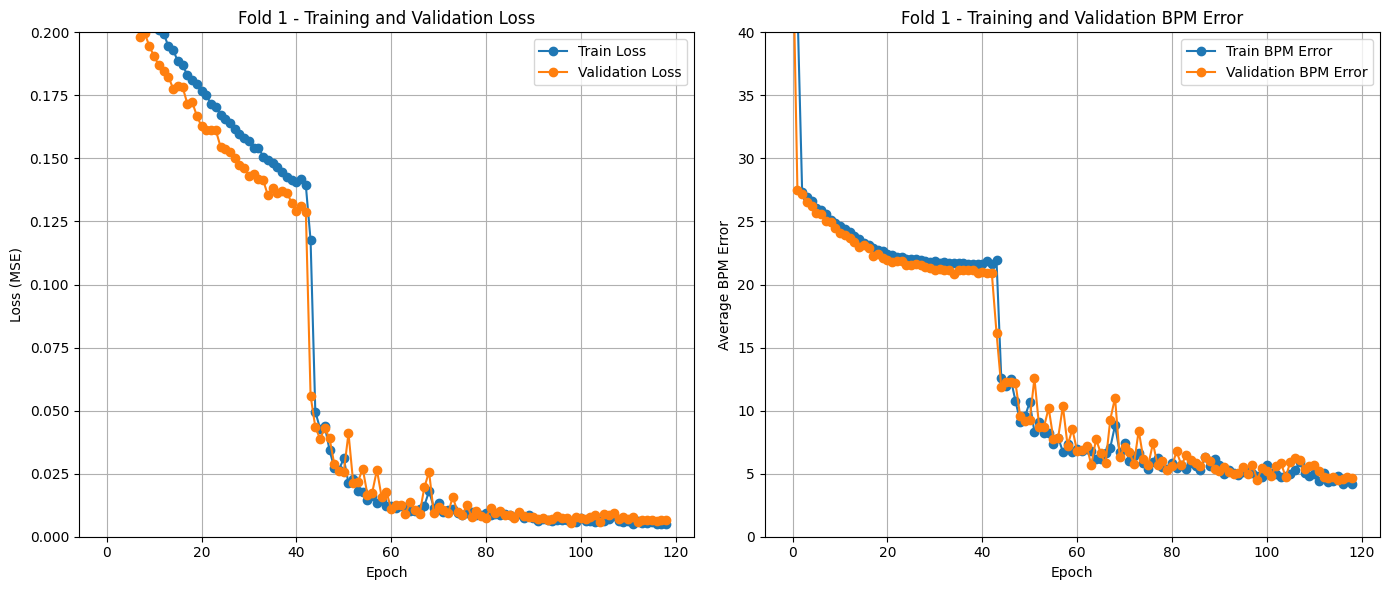

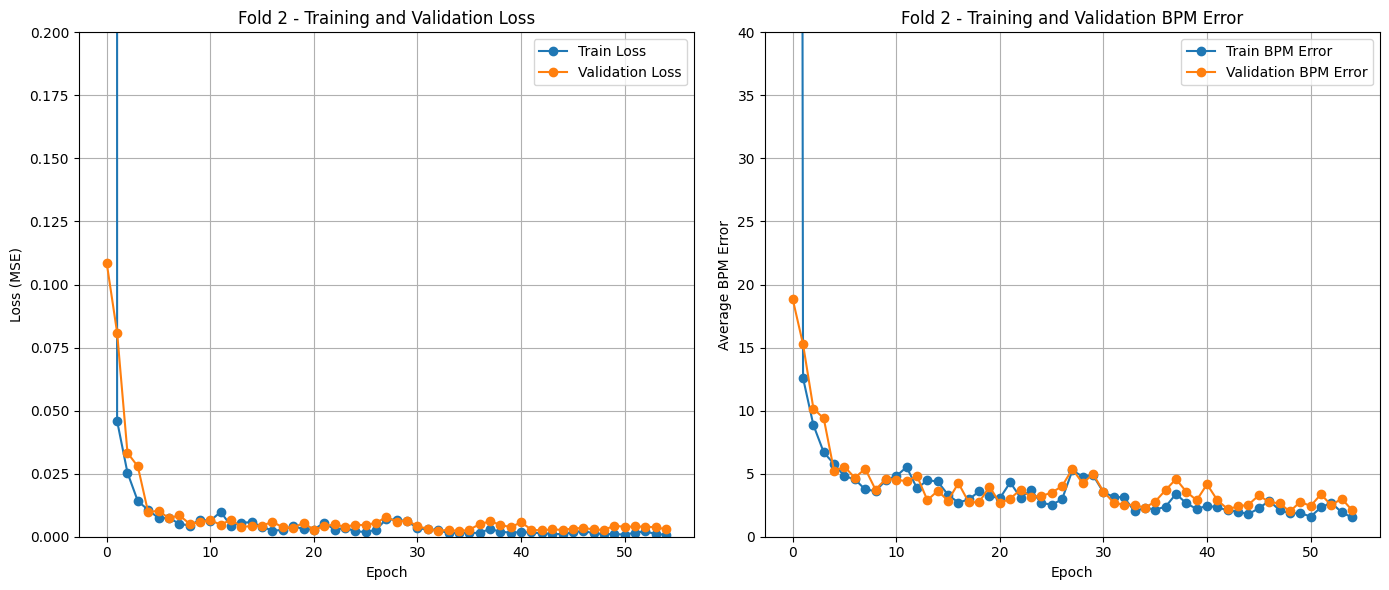

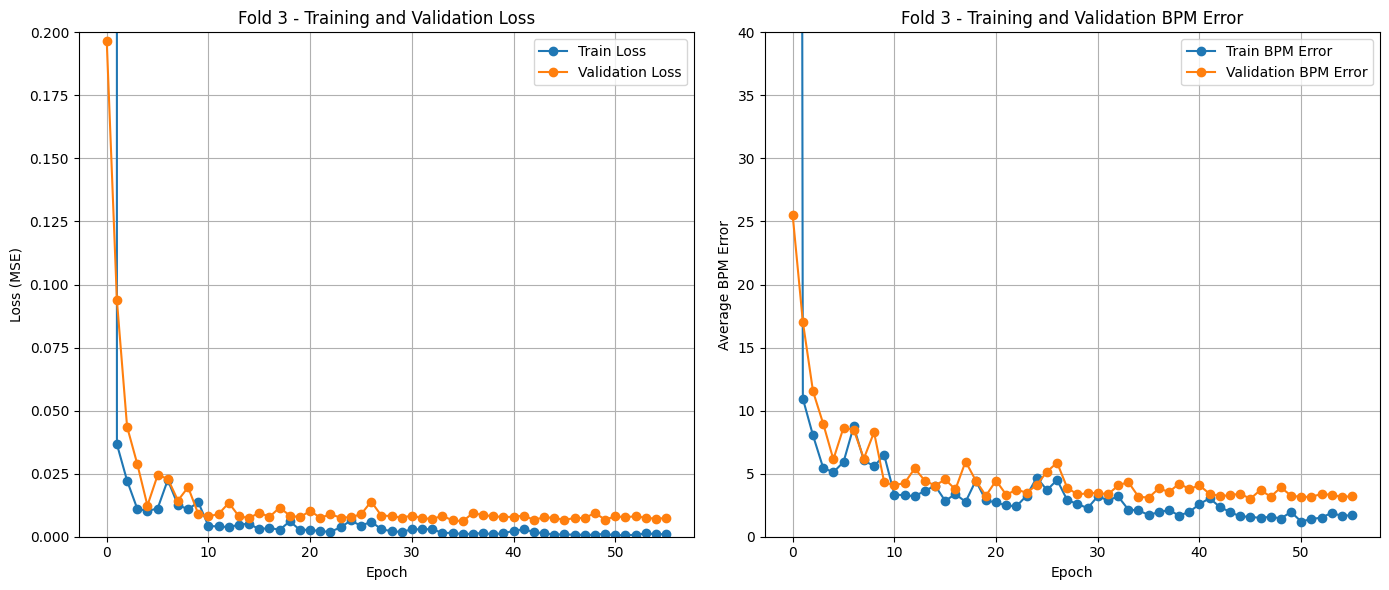

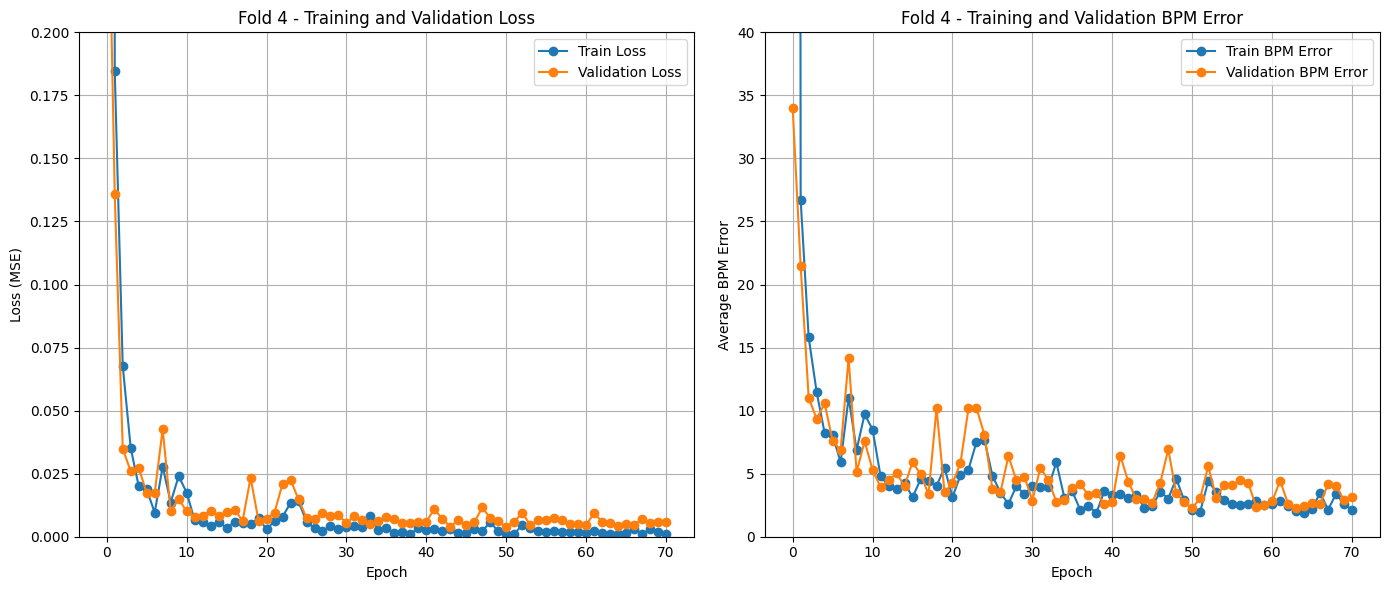

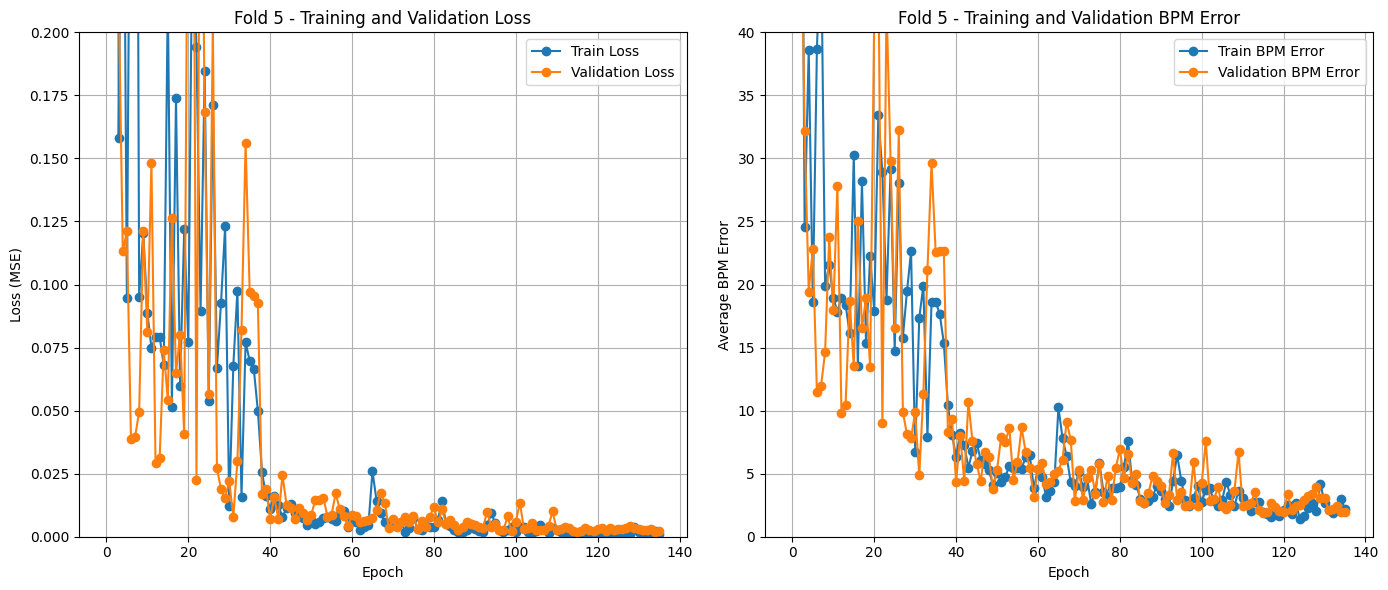

K-Fold Cross Validation Results Summary
Fold 1:
  Final Training Loss: 0.0050
  Final Validation Loss: 0.0068
  Final Training BPM Error: 4.16
  Final Validation BPM Error: 4.69
---------------------------------------
Fold 2:
  Final Training Loss: 0.0008
  Final Validation Loss: 0.0029
  Final Training BPM Error: 1.53
  Final Validation BPM Error: 2.10
---------------------------------------
Fold 3:
  Final Training Loss: 0.0010
  Final Validation Loss: 0.0074
  Final Training BPM Error: 1.72
  Final Validation BPM Error: 3.22
---------------------------------------
Fold 4:
  Final Training Loss: 0.0012
  Final Validation Loss: 0.0058
  Final Training BPM Error: 2.14
  Final Validation BPM Error: 3.18
---------------------------------------
Fold 5:
  Final Training Loss: 0.0012
  Final Validation Loss: 0.0021
  Final Training BPM Error: 2.20
  Final Validation BPM Error: 1.95
---------------------------------------
Overall Cross-Validation Performance:
  Average Training Loss: 0.0018


<Figure size 640x480 with 0 Axes>

In [ ]:
for fold in range(k_folds):
    epochs_range = list(range(len(fold_train_losses[fold])))
    plt.figure(figsize=(14, 6))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, fold_train_losses[fold], label='Train Loss', marker='o')
    plt.plot(epochs_range, fold_val_losses[fold], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.ylim(0, .2)
    plt.title(f'Fold {fold+1} - Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # BPM error plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, fold_train_bpm_errors[fold], label='Train BPM Error', marker='o')
    plt.plot(epochs_range, fold_val_bpm_errors[fold], label='Validation BPM Error', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average BPM Error')
    plt.title(f'Fold {fold+1} - Training and Validation BPM Error')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    # set y range between 0 and 100
    plt.ylim(0, 40)
    plt.show()

plt.tight_layout()
# Text summary
print("K-Fold Cross Validation Results Summary")
print("=======================================")
for fold in range(k_folds):
    print(f"Fold {fold + 1}:")
    print(f"  Final Training Loss: {fold_train_losses[fold][-1]:.4f}")
    print(f"  Final Validation Loss: {fold_val_losses[fold][-1]:.4f}")
    print(f"  Final Training BPM Error: {fold_train_bpm_errors[fold][-1]:.2f}")
    print(f"  Final Validation BPM Error: {fold_val_bpm_errors[fold][-1]:.2f}")
    print("---------------------------------------")

print("Overall Cross-Validation Performance:")
print(f"  Average Training Loss: {avg_train_loss:.4f}")
print(f"  Average Validation Loss: {avg_val_loss:.4f}")
print(f"  Average Training BPM Error: {avg_train_bpm_error:.2f}")
print(f"  Average Validation BPM Error: {avg_val_bpm_error:.2f}")


In [ ]:
test_audio_dir = os.path.join(os.getcwd(), 'TellerNet', 'data', 'beatbank_inf_audios')

test_dataset = RekordboxAudioDataset(test_audio_dir, target_length=1292)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f'successfully loaded {len(test_dataset)} test files')

successfully loaded 37 test files


# Ensemble vs best model

### Best model

In [ ]:
best_model_path = 'pths/model_fold2_20241203_140553.pth'
best_model = TempoEstimationCNN().to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=False))


<All keys matched successfully>

In [ ]:
# Function to descale tempo
def descale_tempo(scaled_tempo):
    return scaled_tempo * 77 + 78

# Lists to store results
best_model_predictions = []
best_model_errors = []

best_model.eval()
with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device).permute(0, 1, 2)  # Ensure features are (batch_size, channels, length)
        true_tempo_norm = target.item()
        true_tempo = descale_tempo(true_tempo_norm)
        output = best_model(features)
        predicted_tempo_norm = output.cpu().item()
        predicted_tempo = descale_tempo(predicted_tempo_norm)
        error = abs(predicted_tempo - true_tempo)
        best_model_predictions.append((true_tempo, predicted_tempo, error))
        best_model_errors.append(error)

# Print the results
print("\nInference Results using Best Model (Fold 2):")
print("True Tempo\tPredicted Tempo\tError (BPM)")
for result in best_model_predictions:
    true_tempo, predicted_tempo, error = result
    print(f"{true_tempo:.2f}\t\t{predicted_tempo:.2f}\t\t{error:.2f}")

# Compute average error
average_error_best_model = np.mean(best_model_errors)
print(f"\nAverage BPM Error using Best Model: {average_error_best_model:.2f} BPM")


Inference Results using Best Model (Fold 2):
True Tempo	Predicted Tempo	Error (BPM)
100.00		90.59		9.41
100.00		89.14		10.86
105.00		111.03		6.03
110.00		91.59		18.41
116.00		107.28		8.72
118.00		107.41		10.59
118.00		122.65		4.65
124.00		134.40		10.40
125.00		124.68		0.32
128.00		91.63		36.37
128.00		126.25		1.75
132.00		121.01		10.99
132.00		112.86		19.14
137.00		115.25		21.75
140.00		126.50		13.50
140.00		135.97		4.03
140.00		131.35		8.65
140.00		129.75		10.25
140.00		121.64		18.36
140.00		142.85		2.85
140.00		132.75		7.25
140.00		139.50		0.50
142.00		143.46		1.46
145.00		126.21		18.79
145.00		135.92		9.08
145.00		118.52		26.48
152.00		125.80		26.20
155.00		129.11		25.89
80.00		88.81		8.81
87.00		87.87		0.87
87.00		97.51		10.51
87.50		94.48		6.98
89.00		80.07		8.93
90.00		110.39		20.39
90.00		93.19		3.19
96.00		94.52		1.48
96.00		95.90		0.10

Average BPM Error using Best Model: 10.92 BPM


In [ ]:
# Load all models for the ensemble
model_paths = [
    'pths/model_fold1_20241203_140536.pth',
    'pths/model_fold2_20241203_140553.pth',
    'pths/model_fold3_20241203_140611.pth',
    'pths/model_fold4_20241203_140633.pth',
    'pths/model_fold5_20241203_140716.pth',
]

ensemble_models = []
for path in model_paths:
    model = TempoEstimationCNN().to(device)
    model.load_state_dict(torch.load(path, map_location=device, weights_only=False))
    model.eval()
    ensemble_models.append(model)

In [ ]:
ensemble_predictions = []
ensemble_errors = []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device).permute(0, 1, 2)
        true_tempo_norm = target.item()
        true_tempo = descale_tempo(true_tempo_norm)
        outputs = []
        for model in ensemble_models:
            output = model(features)
            outputs.append(output.cpu().item())
        # Average the outputs
        predicted_tempo_norm = np.mean(outputs)
        predicted_tempo = descale_tempo(predicted_tempo_norm)
        error = abs(predicted_tempo - true_tempo)
        ensemble_predictions.append((true_tempo, predicted_tempo, error))
        ensemble_errors.append(error)

# Print the results
print("\nInference Results using Ensemble of Models:")
print("True Tempo\tPredicted Tempo\tError (BPM)")
for result in ensemble_predictions:
    true_tempo, predicted_tempo, error = result
    print(f"{true_tempo:.2f}\t\t{predicted_tempo:.2f}\t\t{error:.2f}")

# Compute average error
average_error_ensemble = np.mean(ensemble_errors)
print(f"\nAverage BPM Error using Ensemble: {average_error_ensemble:.2f} BPM")


Inference Results using Ensemble of Models:
True Tempo	Predicted Tempo	Error (BPM)
100.00		93.69		6.31
116.00		102.72		13.28
140.00		128.10		11.90
140.00		138.82		1.18
80.00		92.14		12.14
87.00		94.97		7.97
87.50		88.87		1.37
96.00		95.03		0.97

Average BPM Error using Ensemble: 6.89 BPM
